# Backorder Prediction

### Load the libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from imblearn.combine import SMOTEENN

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler

### Load the Dataset

In [4]:
train_df = pd.read_csv('D:/backorder data/training data/Kaggle_Training_Dataset_v2.csv')
test_df = pd.read_csv('D:/backorder data/testing data/Kaggle_Test_Dataset_v2.csv')

#merge
train_test_df=pd.concat([train_df, test_df], axis=0, ignore_index=True)

#store the merged dataset into local storage
train_test_df.to_csv('D:/backorder data/training data/merged_train_test.csv', index=False)

C:\Users\abhir\AppData\Local\Temp\ipykernel_20544\2756379363.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('D:/backorder data/training data/Kaggle_Training_Dataset_v2.csv')
C:\Users\abhir\AppData\Local\Temp\ipykernel_20544\2756379363.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('D:/backorder data/testing data/Kaggle_Test_Dataset_v2.csv')


In [5]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [6]:
train_test_df.shape

(1929937, 23)

In [7]:
train_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1929937 entries, 0 to 1929936
Data columns (total 23 columns):
 #   Column             Dtype  
---  ------             -----  
 0   sku                object 
 1   national_inv       float64
 2   lead_time          float64
 3   in_transit_qty     float64
 4   forecast_3_month   float64
 5   forecast_6_month   float64
 6   forecast_9_month   float64
 7   sales_1_month      float64
 8   sales_3_month      float64
 9   sales_6_month      float64
 10  sales_9_month      float64
 11  min_bank           float64
 12  potential_issue    object 
 13  pieces_past_due    float64
 14  perf_6_month_avg   float64
 15  perf_12_month_avg  float64
 16  local_bo_qty       float64
 17  deck_risk          object 
 18  oe_constraint      object 
 19  ppap_risk          object 
 20  stop_auto_buy      object 
 21  rev_stop           object 
 22  went_on_backorder  object 
dtypes: float64(15), object(8)
memory usage: 338.7+ MB


In [8]:
train_test_df.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


In [9]:
train_test_df.describe().apply(lambda s: s.apply('{0:.5f}'.format))
# .apply(lambda s: s.apply('{0:.5f}'.format)) helps change the format of the output from exponential to float type.
# apply() is a function specifically used in pandas to apply a function along n axis of a dataframe

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
count,1929935.00000,1814318.00000,1929935.00000,1929935.00000,1929935.00000,1929935.00000,1929935.00000,1929935.00000,1929935.00000,1929935.00000,1929935.00000,1929935.00000,1929935.00000,1929935.00000,1929935.00000
mean,496.56826,7.87863,43.06440,178.53986,345.46589,506.60675,55.36816,174.66386,341.56535,523.57709,52.77637,2.01619,-6.89987,-6.46234,0.65370
std,29573.43434,7.05421,1295.42049,5108.77017,9831.56208,14345.43087,1884.37701,5188.85585,9585.03038,14733.26563,1257.96826,229.61124,26.59988,25.88343,35.43230
min,-27256.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-99.00000,-99.00000,0.00000
25%,4.00000,4.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.63000,0.66000,0.00000
50%,15.00000,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,2.00000,4.00000,0.00000,0.00000,0.82000,0.81000,0.00000
75%,80.00000,9.00000,0.00000,4.00000,12.00000,20.00000,4.00000,15.00000,31.00000,47.00000,3.00000,0.00000,0.96000,0.95000,0.00000
max,12334404.00000,52.00000,489408.00000,1510592.00000,2461360.00000,3777304.00000,741774.00000,1105478.00000,2146625.00000,3205172.00000,313319.00000,146496.00000,1.00000,1.00000,12530.00000


### Handling NULL values

In [10]:
train_test_df.isnull().sum()
# train_df.isnull().sum().sum() -> return total null values

sku                       0
national_inv              2
lead_time            115619
in_transit_qty            2
forecast_3_month          2
forecast_6_month          2
forecast_9_month          2
sales_1_month             2
sales_3_month             2
sales_6_month             2
sales_9_month             2
min_bank                  2
potential_issue           2
pieces_past_due           2
perf_6_month_avg          2
perf_12_month_avg         2
local_bo_qty              2
deck_risk                 2
oe_constraint             2
ppap_risk                 2
stop_auto_buy             2
rev_stop                  2
went_on_backorder         2
dtype: int64

In [11]:
train_test_df[train_test_df.national_inv.isnull()]
#this is the SKU that has all values as NULL (NaN).

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1687860,(1687860 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1929936,(242075 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
train_test_df.drop([1687860], inplace = True)
train_test_df.drop([1929936], inplace = True)

In [13]:
train_test_df.isnull().sum()


sku                       0
national_inv              0
lead_time            115617
in_transit_qty            0
forecast_3_month          0
forecast_6_month          0
forecast_9_month          0
sales_1_month             0
sales_3_month             0
sales_6_month             0
sales_9_month             0
min_bank                  0
potential_issue           0
pieces_past_due           0
perf_6_month_avg          0
perf_12_month_avg         0
local_bo_qty              0
deck_risk                 0
oe_constraint             0
ppap_risk                 0
stop_auto_buy             0
rev_stop                  0
went_on_backorder         0
dtype: int64

In [14]:
train_test_df.sku = train_test_df.sku.astype(np.int64)
train_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1929935 entries, 0 to 1929935
Data columns (total 23 columns):
 #   Column             Dtype  
---  ------             -----  
 0   sku                int64  
 1   national_inv       float64
 2   lead_time          float64
 3   in_transit_qty     float64
 4   forecast_3_month   float64
 5   forecast_6_month   float64
 6   forecast_9_month   float64
 7   sales_1_month      float64
 8   sales_3_month      float64
 9   sales_6_month      float64
 10  sales_9_month      float64
 11  min_bank           float64
 12  potential_issue    object 
 13  pieces_past_due    float64
 14  perf_6_month_avg   float64
 15  perf_12_month_avg  float64
 16  local_bo_qty       float64
 17  deck_risk          object 
 18  oe_constraint      object 
 19  ppap_risk          object 
 20  stop_auto_buy      object 
 21  rev_stop           object 
 22  went_on_backorder  object 
dtypes: float64(15), int64(1), object(7)
memory usage: 353.4+ MB


### Handling the Missing Values

In [15]:
train_test_df_copy = train_test_df.copy()

In [16]:
train_test_df_copy.isnull().sum()

sku                       0
national_inv              0
lead_time            115617
in_transit_qty            0
forecast_3_month          0
forecast_6_month          0
forecast_9_month          0
sales_1_month             0
sales_3_month             0
sales_6_month             0
sales_9_month             0
min_bank                  0
potential_issue           0
pieces_past_due           0
perf_6_month_avg          0
perf_12_month_avg         0
local_bo_qty              0
deck_risk                 0
oe_constraint             0
ppap_risk                 0
stop_auto_buy             0
rev_stop                  0
went_on_backorder         0
dtype: int64

In [17]:
train_test_df_copy.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


[Text(0.5, 1.0, 'Lead Time Range and Distribution')]

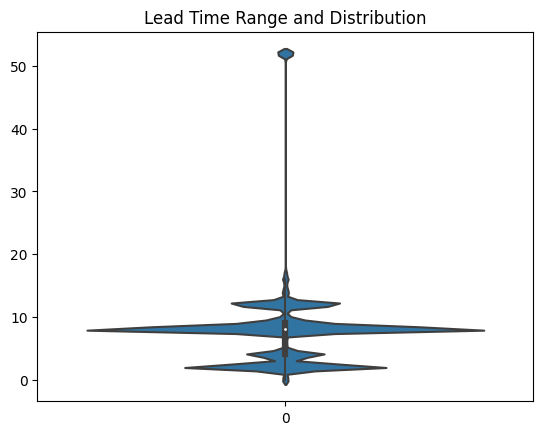

In [18]:
sns.violinplot(train_test_df_copy['lead_time']).set(title='Lead Time Range and Distribution')

In [19]:
#percentage of NULL values in lead_time
100893/len(train_test_df_copy.lead_time) * 100

5.2277926458663115

In [20]:
train_test_df_copy['lead_time'].median()

8.0

In [21]:
train_test_df_copy['lead_time'] = train_test_df_copy['lead_time'].fillna(8.0)
train_test_df_copy['lead_time'].isnull().sum()


0

In [22]:
train_test_df_copy.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


In [23]:
train_test_df_copy.isnull().sum()

sku                  0
national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64

In [24]:
train_test_df_copy['perf_6_month_avg'].value_counts()

 0.99     163323
 1.00     150339
-99.00    148579
 0.73     128818
 0.98      97390
           ...  
 0.20        921
 0.03        829
 0.04        724
 0.01        648
 0.29        572
Name: perf_6_month_avg, Length: 102, dtype: int64

In [25]:
train_test_df_copy['perf_12_month_avg'].value_counts()

 0.99     152682
-99.00    140025
 0.78     131353
 0.98     106119
 0.97      74113
           ...  
 0.23        895
 0.06        873
 0.05        743
 0.03        639
 0.02        437
Name: perf_12_month_avg, Length: 102, dtype: int64

In [26]:
print("percentage of -99(missing values) in perf_6_month_avg: ", 129478 / len(train_test_df_copy.index) * 100)
print("percentage of -99(missing values) in perf_12_month_avg", 122050 / len(train_test_df_copy.index) * 100)

percentage of -99(missing values) in perf_6_month_avg:  6.708930611652724
percentage of -99(missing values) in perf_12_month_avg 6.324047182936213


[Text(0.5, 1.0, 'Source Performance Range and Distribution')]

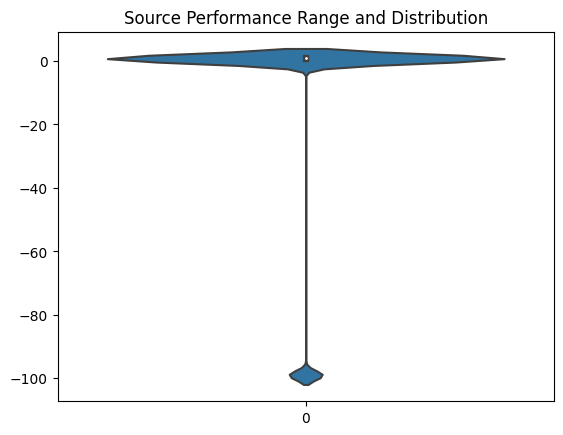

In [27]:
sns.violinplot(train_test_df_copy.perf_6_month_avg).set(title='Source Performance Range and Distribution')

[Text(0.5, 1.0, 'Source Performance Range and Distribution')]

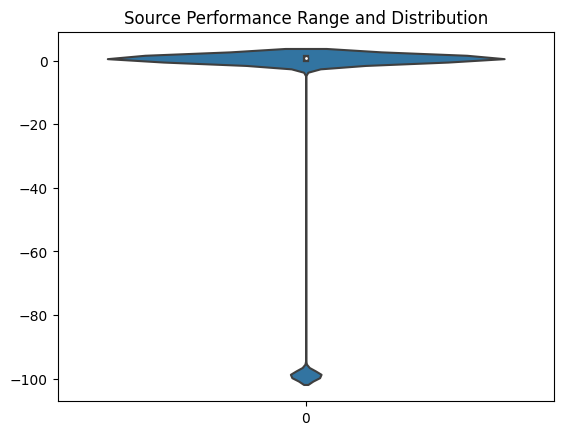

In [28]:
sns.violinplot(train_test_df_copy.perf_12_month_avg).set(title='Source Performance Range and Distribution')

In [29]:
train_test_df_copy.perf_6_month_avg.median()

0.82

In [30]:
train_test_df_copy.perf_12_month_avg.median()

0.81

In [31]:
#Replace -99 with NAN in the perf_12_month_avg and perf_6_month_avg
train_test_df_copy['perf_12_month_avg'].replace({-99.00:np.nan}, inplace = True)
train_test_df_copy['perf_6_month_avg'].replace({-99.00:np.nan}, inplace = True)

In [32]:
#Imputing the missing values in the perf_6_month_avg field with the median values
train_test_df_copy.perf_6_month_avg.fillna(train_test_df_copy.perf_6_month_avg.median(), inplace=True)
train_test_df_copy['perf_6_month_avg'].isnull().sum()


0

In [33]:
#Imputing the missing values in the perf_12_month_avg field with the median values
train_test_df_copy.perf_12_month_avg.fillna(train_test_df_copy.perf_12_month_avg.median(), inplace = True)
train_test_df_copy['perf_12_month_avg'].isnull().sum()


0

In [34]:
train_test_df_copy.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.85,0.83,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.85,0.83,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,0.85,0.83,0.0,Yes,No,No,Yes,No,No


[Text(0.5, 1.0, 'Source Performance Range and Distribution')]

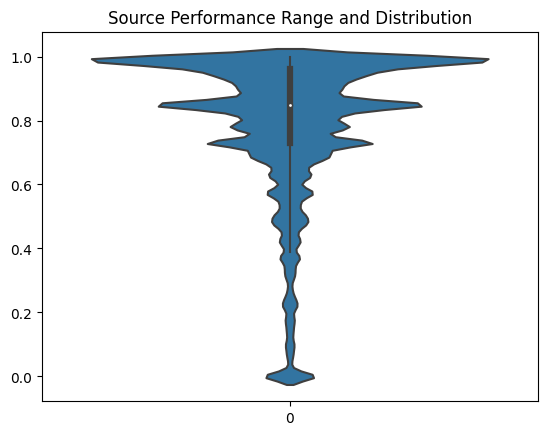

In [35]:
sns.violinplot(train_test_df_copy.perf_6_month_avg).set(title='Source Performance Range and Distribution')

[Text(0.5, 1.0, 'Source Performance Range and Distribution')]

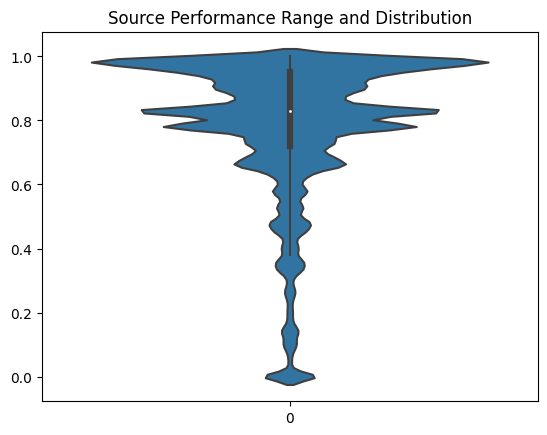

In [36]:
sns.violinplot(train_test_df_copy.perf_12_month_avg).set(title='Source Performance Range and Distribution')

In [37]:
# source_perf_columns = ['perf_6_month_avg','perf_12_month_avg']
# source_perf_list = []

# for i in source_perf_columns:
#     source_perf_list.append(train_df_copy[i].tolist())

In [38]:
# source_perf_columns = ['perf_6_month_avg','perf_12_month_avg']
# source_perf_columns_df = train_df_copy[source_perf_columns].copy()

subset_data = train_test_df_copy.sample(5000)
sourceperf_corr_df = subset_data[['perf_6_month_avg','perf_12_month_avg']]
sourceperf_corr = sourceperf_corr_df.corr()
sourceperf_corr

,perf_6_month_avg,perf_12_month_avg
perf_6_month_avg,1.0000,0.9295
perf_12_month_avg,0.9295,1.0000


In [39]:
# source_perf_columns_df.corr()

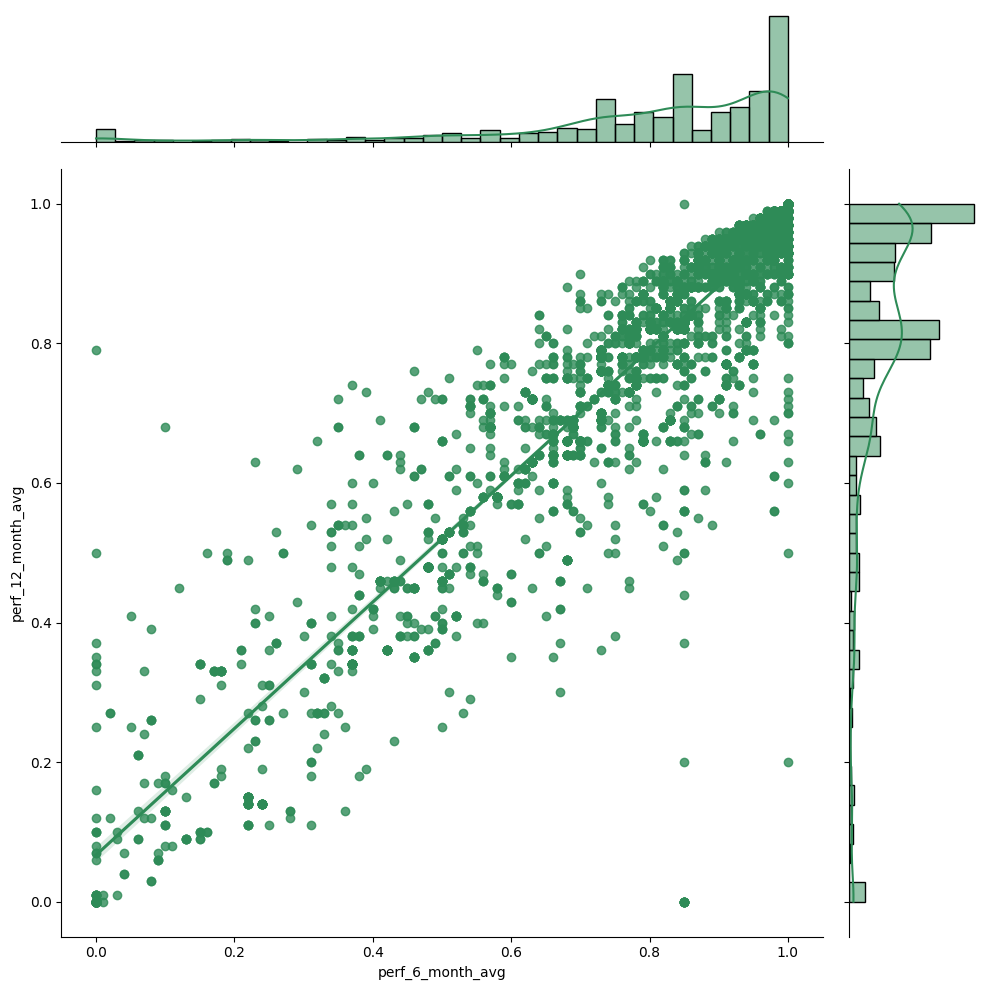

In [40]:
scattered_plot = sns.jointplot(x='perf_6_month_avg', y='perf_12_month_avg', data = subset_data, kind= 'reg', color= 'seagreen', height=10)

In [41]:
prior_sales_corr_df = subset_data[['sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month']]
prior_sales_corr = prior_sales_corr_df.corr()
prior_sales_corr

,sales_1_month,sales_3_month,sales_6_month,sales_9_month
sales_1_month,1.000000,0.963688,0.915260,0.915416
sales_3_month,0.963688,1.000000,0.981132,0.977927
sales_6_month,0.915260,0.981132,1.000000,0.998137
sales_9_month,0.915416,0.977927,0.998137,1.000000


In [42]:
# prior_sales_scatter_plot = sns.jointplot(x='sales_1_month', y='sales_9_month', data = subset_data, color='lightseagreen', kind = 'reg', height=10)
# we need to limit the axes in order to visualize properly.

#prior_sales_scatter_plot = sns.jointplot(x='sales_1_month', y='sales_9_month', data = subset_data, color='lightseagreen', kind = 'reg', height=10, xlim=(0, 500), ylim=(0, 5000))

(0.0, 5000.0)

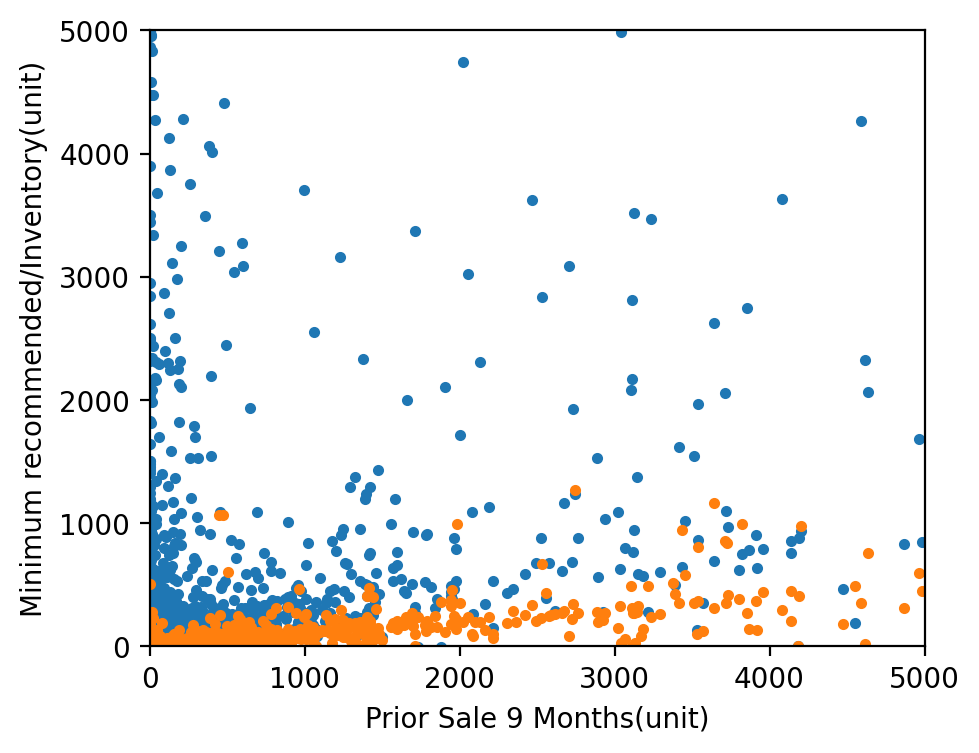

In [43]:
plt.figure(figsize=(5,4),dpi=200)

plt.plot(subset_data.sales_9_month, subset_data.national_inv, marker = '.', linestyle = 'None' )
plt.xlabel('Prior Sale 9 Months(unit)')
plt.ylabel('Current Inventory(unit)')
plt.plot(subset_data.sales_9_month, subset_data.min_bank, marker = '.', linestyle = 'None' )
plt.xlabel('Prior Sale 9 Months(unit)')
plt.ylabel('Minimum recommended/Inventory(unit)')
plt.xlim(0,5000)
plt.ylim(0,5000)

In [44]:
train_test_df_copy.describe(include='object')
#shows that there are just 2 unique values for each object type parameter.

,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,1929935,1929935,1929935,1929935,1929935,1929935,1929935
unique,2,2,2,2,2,2,2
top,No,No,No,No,Yes,No,No
freq,1928946,1494482,1929643,1697383,1859391,1929096,1915954


<AxesSubplot:xlabel='deck_risk', ylabel='count'>

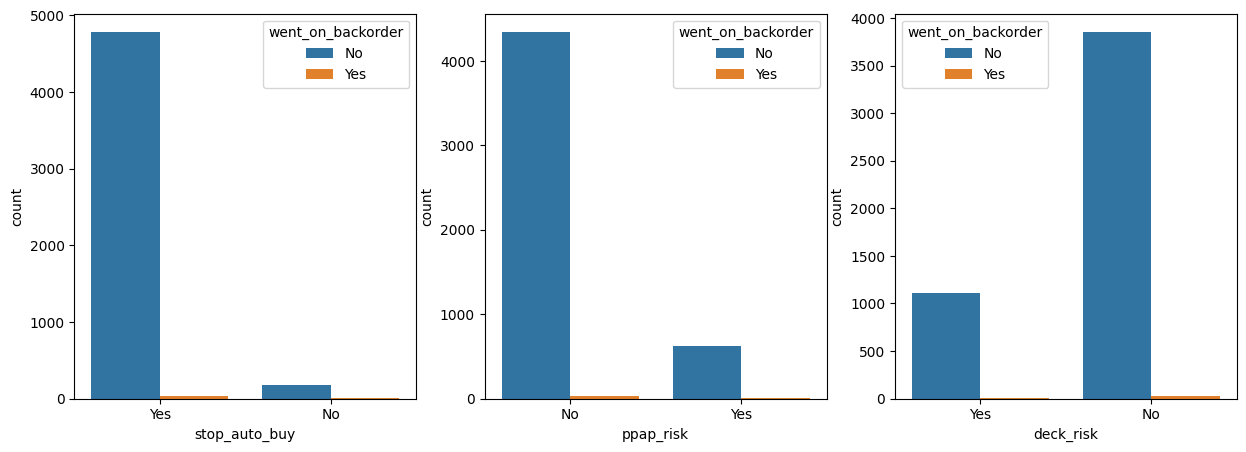

In [45]:
fig, ax = plt.subplots(ncols = 3, figsize=(15, 5))
sns.countplot(x='stop_auto_buy', hue = 'went_on_backorder', data = subset_data, ax = ax[0])
sns.countplot(x='ppap_risk', hue = 'went_on_backorder', data = subset_data, ax = ax[1])
sns.countplot(x='deck_risk', hue = 'went_on_backorder', data = subset_data, ax = ax[2])

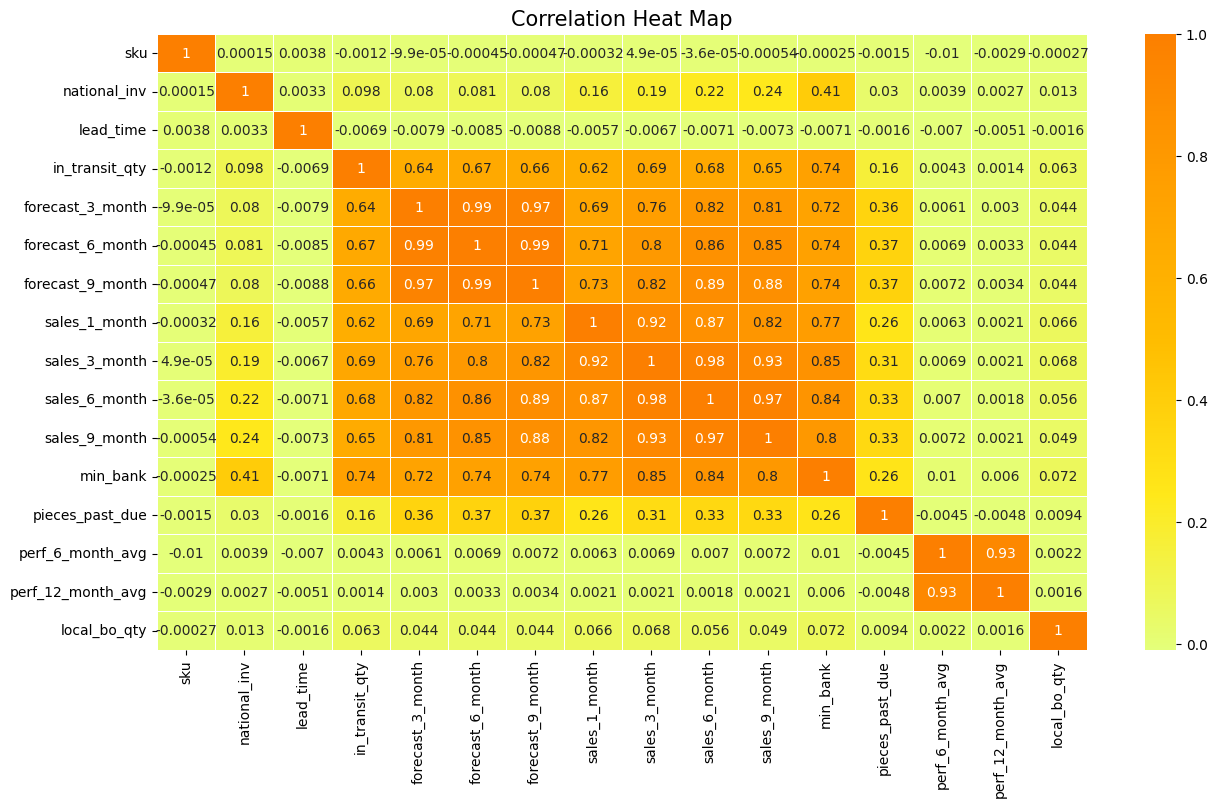

In [46]:
plt.figure(figsize=(15,8))
sns.heatmap(train_test_df_copy.corr(), annot = True, linewidth = 0.5, cmap = 'Wistia')
plt.title('Correlation Heat Map', fontsize = 15)
plt.show()

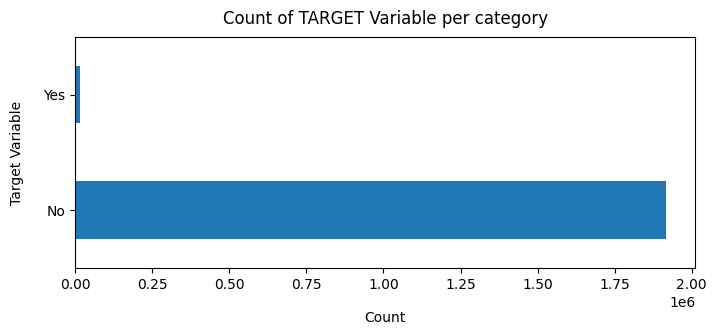

In [47]:
#For classification problems, always have a look at the ratio of the output categories.
train_test_df_copy['went_on_backorder'].value_counts().plot(kind='barh', figsize=(8, 3))
plt.xlabel("Count", labelpad=14)
plt.ylabel("Target Variable", labelpad=14)
plt.title("Count of TARGET Variable per category", y=1.02);

In [48]:
train_test_df_copy.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.85,0.83,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.85,0.83,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,0.85,0.83,0.0,Yes,No,No,Yes,No,No


#### Handling Outliers

<AxesSubplot:>

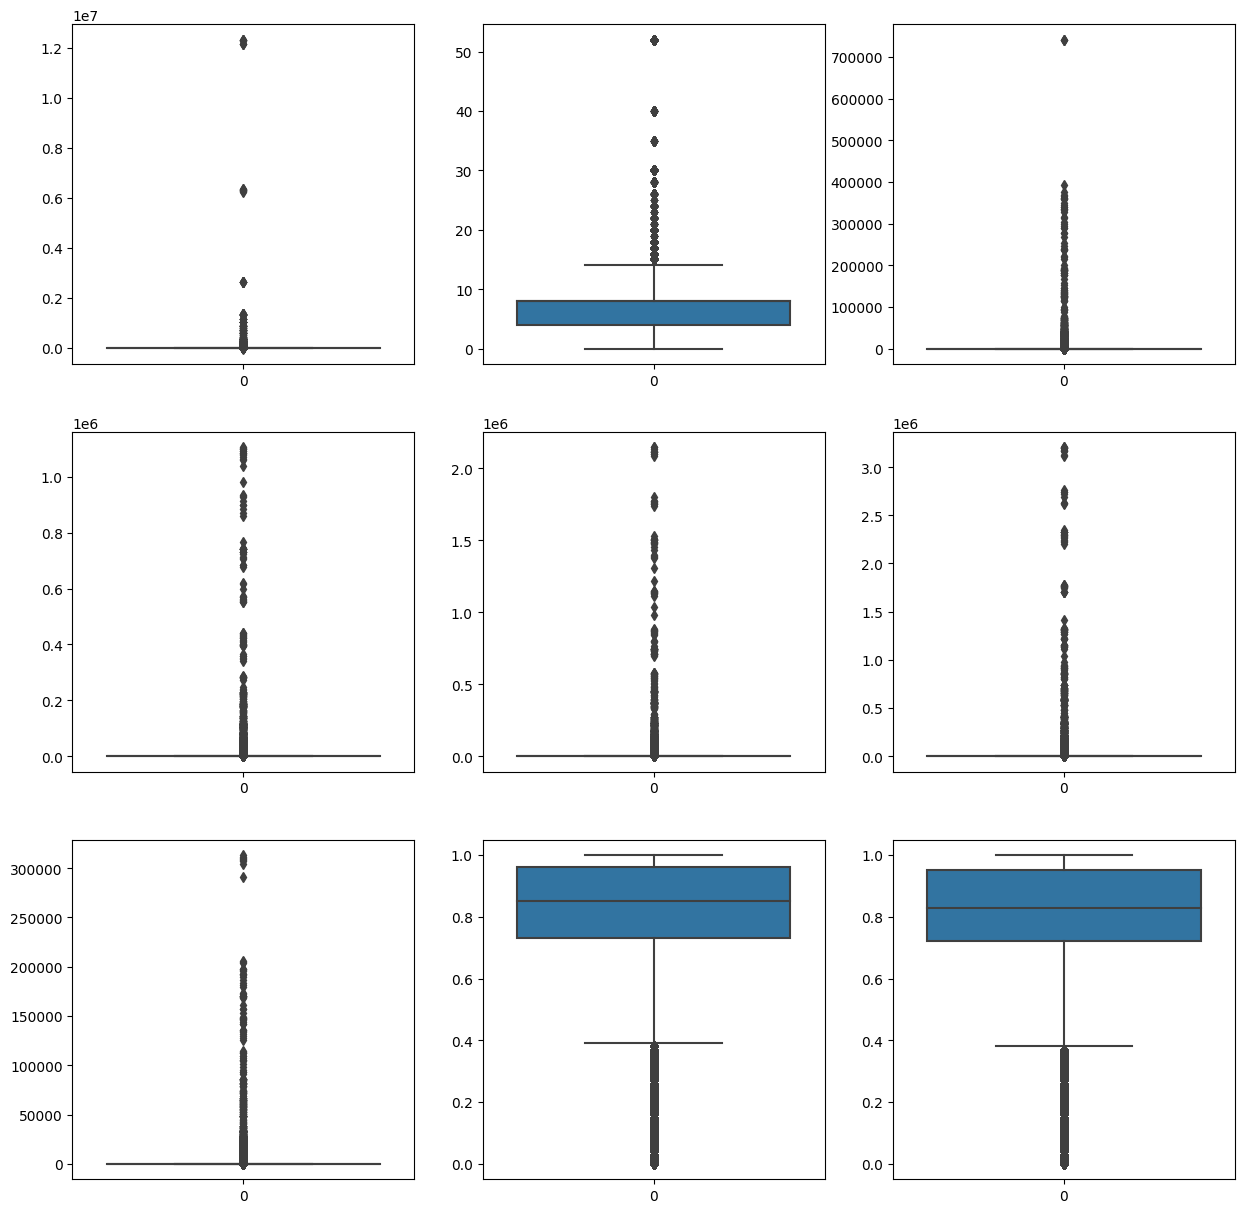

In [49]:
nrows = 3
ncols = 3
fig, ax1 = plt.subplots(nrows, ncols, figsize = (15, 15))
sns.boxplot(train_test_df_copy.national_inv, ax = ax1[0,0])
sns.boxplot(train_test_df_copy.lead_time, ax = ax1[0,1])
sns.boxplot(train_test_df_copy.sales_1_month, ax = ax1[0,2])
sns.boxplot(train_test_df_copy.sales_3_month, ax = ax1[1,0])
sns.boxplot(train_test_df_copy.sales_6_month, ax = ax1[1,1])
sns.boxplot(train_test_df_copy.sales_9_month, ax = ax1[1,2])
sns.boxplot(train_test_df_copy.min_bank, ax = ax1[2,0])
sns.boxplot(train_test_df_copy.perf_6_month_avg, ax = ax1[2,1])
sns.boxplot(train_test_df_copy.perf_12_month_avg, ax = ax1[2,2])

In [50]:
train_test_df_copy.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.85,0.83,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.85,0.83,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,0.85,0.83,0.0,Yes,No,No,Yes,No,No


In [51]:
#dropping outliers of minimum recommended stock
outlier_minimum_recommended_stock = train_test_df_copy[train_test_df_copy['min_bank'] > 250000]
outlier_minimum_recommended_stock.shape

(8, 23)

In [52]:
#lets delete the outlier of the minimum_recommend_stock
train_test_df_copy = train_test_df_copy.drop(outlier_minimum_recommended_stock.index, errors = 'ignore')

In [53]:
outlier_current_inventory = train_test_df_copy[train_test_df_copy.national_inv > .2e07]
outlier_current_inventory.shape

(24, 23)

In [54]:
#lets delete the outlier of the outlier_current_inventory
train_test_df_copy = train_test_df_copy.drop(outlier_current_inventory.index, errors = 'ignore')

#### Drop features if ~70% not available

[Text(0.5, 1.0, 'forecast sales of 3 months')]

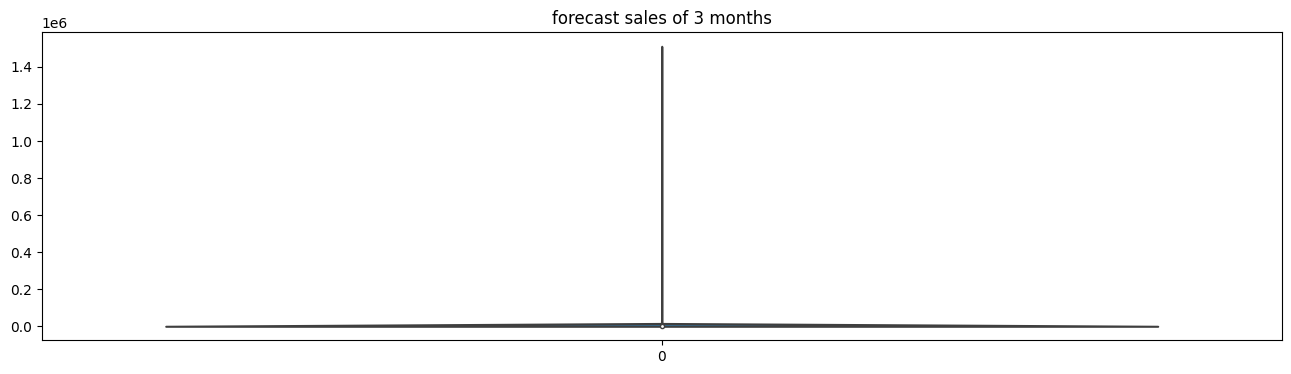

In [55]:
plt.figure(figsize=(16,4))
sns.violinplot(train_test_df_copy['forecast_3_month']).set(title='forecast sales of 3 months')

[Text(0.5, 1.0, 'forecast sales of 6 months')]

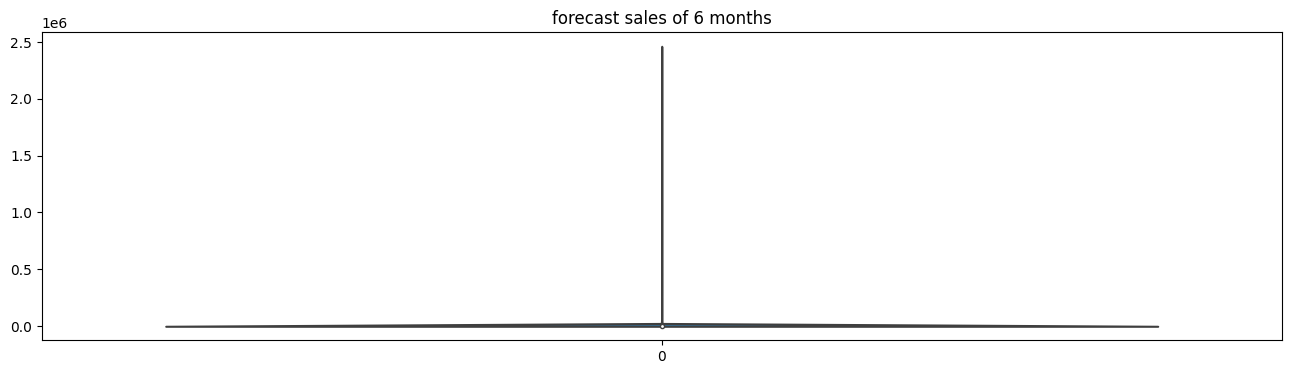

In [56]:
plt.figure(figsize=(16,4))
sns.violinplot(train_test_df_copy['forecast_6_month']).set(title='forecast sales of 6 months')

[Text(0.5, 1.0, 'forecast sales of 9 months')]

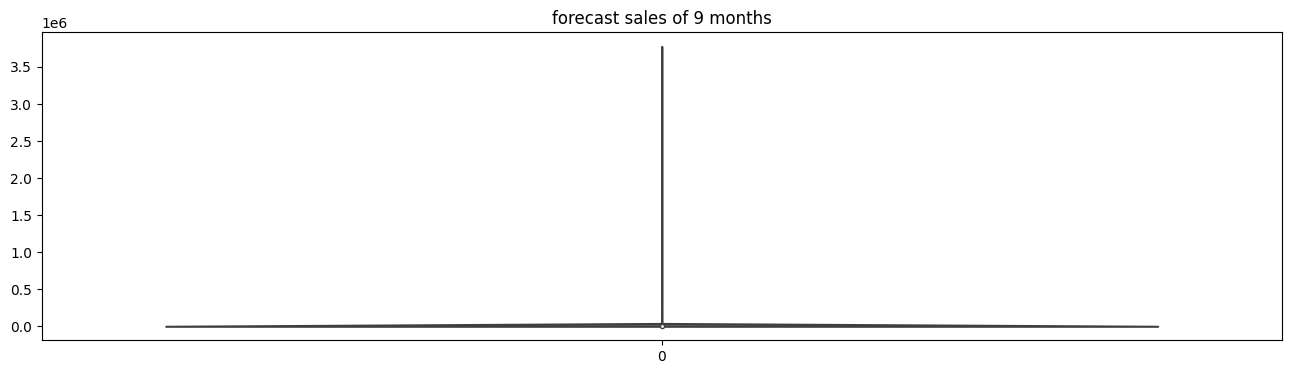

In [57]:
plt.figure(figsize=(16,4))
sns.violinplot(train_test_df_copy['forecast_9_month']).set(title='forecast sales of 9 months')

In [58]:
train_test_df_copy = train_test_df_copy.drop(['forecast_3_month', 'forecast_6_month',
                             'forecast_9_month'], axis = 1)

In [59]:
train_test_df_copy['pieces_past_due'].value_counts()
1662543*100/len(train_test_df_copy.index)

86.14645399276544

In [60]:
train_test_df_copy['local_bo_qty'].value_counts()
1664494*100/len(train_test_df_copy.index)

86.24754715651513

In [61]:
train_test_df_copy = train_test_df_copy.drop(['local_bo_qty', 'pieces_past_due'], axis = 1)

In [62]:
train_test_df_copy.head()

,sku,national_inv,lead_time,in_transit_qty,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,perf_6_month_avg,perf_12_month_avg,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.85,0.83,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.99,0.99,No,No,No,Yes,No,No
2,1043696,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.85,0.83,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.10,0.13,No,No,No,Yes,No,No
4,1044048,8.0,8.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.85,0.83,Yes,No,No,Yes,No,No


In [63]:
train_test_df_copy.shape

(1929903, 18)

### Categorical to Numerical Features

In [64]:
categorical_columns = []
columns = train_test_df_copy.columns
print("all columns: ")
for name in columns:
    print(name)
    if train_test_df_copy[name].dtype==object:
        categorical_columns.append(name)
        
print("\ncategorical columns:")
print(categorical_columns)        

all columns: 
sku
national_inv
lead_time
in_transit_qty
sales_1_month
sales_3_month
sales_6_month
sales_9_month
min_bank
potential_issue
perf_6_month_avg
perf_12_month_avg
deck_risk
oe_constraint
ppap_risk
stop_auto_buy
rev_stop
went_on_backorder

categorical columns:
['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']


In [65]:
train_test_df_copy.drop('sku',inplace=True, axis=1)

In [66]:
for name in categorical_columns:
    print(train_test_df_copy[name].value_counts())

No     1928914
Yes        989
Name: potential_issue, dtype: int64
No     1494450
Yes     435453
Name: deck_risk, dtype: int64
No     1929611
Yes        292
Name: oe_constraint, dtype: int64
No     1697367
Yes     232536
Name: ppap_risk, dtype: int64
Yes    1859367
No       70536
Name: stop_auto_buy, dtype: int64
No     1929064
Yes        839
Name: rev_stop, dtype: int64
No     1915922
Yes      13981
Name: went_on_backorder, dtype: int64


In [67]:
for i in categorical_columns:
    train_test_df_copy[i].replace(['No','Yes'],[0,1],inplace=True)

In [68]:
train_test_df_copy.head()

,national_inv,lead_time,in_transit_qty,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,perf_6_month_avg,perf_12_month_avg,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.85,0.83,0,0,0,1,0,0
1,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.99,0.99,0,0,0,1,0,0
2,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.85,0.83,1,0,0,1,0,0
3,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.10,0.13,0,0,0,1,0,0
4,8.0,8.0,0.0,0.0,0.0,0.0,4.0,2.0,0,0.85,0.83,1,0,0,1,0,0


In [69]:
train_test_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1929903 entries, 0 to 1929935
Data columns (total 17 columns):
 #   Column             Dtype  
---  ------             -----  
 0   national_inv       float64
 1   lead_time          float64
 2   in_transit_qty     float64
 3   sales_1_month      float64
 4   sales_3_month      float64
 5   sales_6_month      float64
 6   sales_9_month      float64
 7   min_bank           float64
 8   potential_issue    int64  
 9   perf_6_month_avg   float64
 10  perf_12_month_avg  float64
 11  deck_risk          int64  
 12  oe_constraint      int64  
 13  ppap_risk          int64  
 14  stop_auto_buy      int64  
 15  rev_stop           int64  
 16  went_on_backorder  int64  
dtypes: float64(10), int64(7)
memory usage: 265.0 MB


In [70]:
train_test_df_copy.to_csv('D:/backorder data/train_test_merged_data_cleaned.csv')

In [71]:
# Select the original train dataset
train_data_final = train_test_df_copy.iloc[:1687861, :]

# Select the original test dataset
test_data_final = train_test_df_copy.iloc[1687861:, :]

In [72]:
train_data_final.shape

(1687861, 17)

In [73]:
train_data_final.head()

,national_inv,lead_time,in_transit_qty,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,perf_6_month_avg,perf_12_month_avg,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.85,0.83,0,0,0,1,0,0
1,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.99,0.99,0,0,0,1,0,0
2,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.85,0.83,1,0,0,1,0,0
3,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.10,0.13,0,0,0,1,0,0
4,8.0,8.0,0.0,0.0,0.0,0.0,4.0,2.0,0,0.85,0.83,1,0,0,1,0,0


In [74]:
test_data_final.shape

(242042, 17)

In [75]:
test_data_final.head()

,national_inv,lead_time,in_transit_qty,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,perf_6_month_avg,perf_12_month_avg,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1687890,4.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.85,0.83,0,0,0,1,0,0
1687891,7577.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.00,0,0,0,1,0,0
1687892,16.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.85,0.83,1,0,0,1,0,0
1687893,85.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.85,0.83,0,0,0,1,0,0
1687894,5.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.85,0.83,0,0,0,1,0,0


### Creating independent and dependent variables

In [76]:
x=train_data_final.drop('went_on_backorder', axis=1)
x

,national_inv,lead_time,in_transit_qty,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,perf_6_month_avg,perf_12_month_avg,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.85,0.83,0,0,0,1,0
1,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.99,0.99,0,0,0,1,0
2,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.85,0.83,1,0,0,1,0
3,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.10,0.13,0,0,0,1,0
4,8.0,8.0,0.0,0.0,0.0,0.0,4.0,2.0,0,0.85,0.83,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687885,73.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.85,0.83,1,0,0,1,0
1687886,9.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.85,0.83,1,0,0,1,0
1687887,755.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.85,0.83,0,0,0,1,0
1687888,5.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.85,0.83,0,0,0,1,0


In [77]:
x.isnull().sum()

national_inv         0
lead_time            0
in_transit_qty       0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
perf_6_month_avg     0
perf_12_month_avg    0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
dtype: int64

In [78]:
y=train_data_final['went_on_backorder']
y

0          0
1          0
2          0
3          0
4          0
          ..
1687885    0
1687886    0
1687887    0
1687888    0
1687889    0
Name: went_on_backorder, Length: 1687861, dtype: int64

In [79]:
y.isnull().sum()

0

In [80]:
y.value_counts()

0    1676568
1      11293
Name: went_on_backorder, dtype: int64

<BarContainer object of 2 artists>

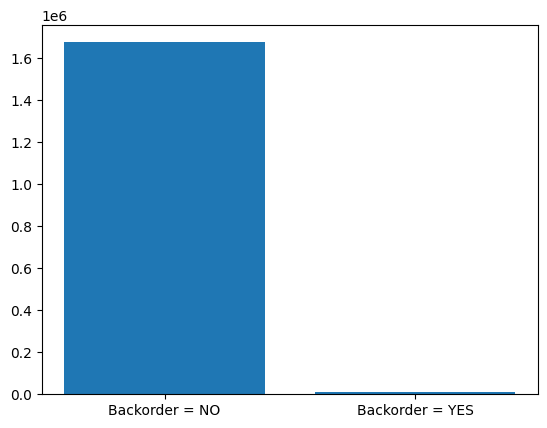

In [81]:
class_names = ['Backorder = NO', 'Backorder = YES']
plt.bar(class_names, y.value_counts())

### Balancing the dataset

In [82]:
# sm = SMOTEENN()
# x_resampled, y_resampled = sm.fit_resample(x, y)

In [83]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler()
x_resampled, y_resampled = oversampler.fit_resample(x, y)
print(y_resampled.value_counts())

0    1676568
1    1676568
Name: went_on_backorder, dtype: int64


In [84]:
# y_resampled.value_counts()

In [85]:
x_resampled.shape

(3353136, 16)

<BarContainer object of 2 artists>

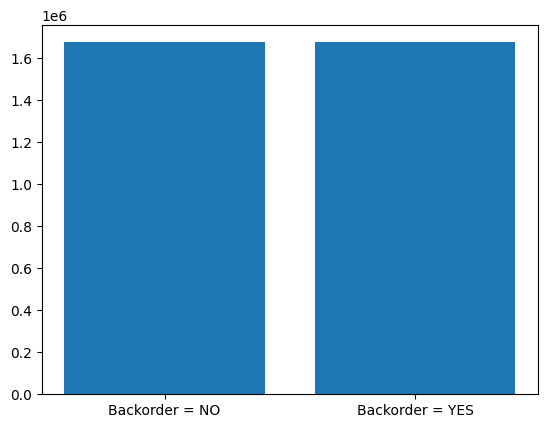

In [86]:
class_names = ['Backorder = NO', 'Backorder = YES']
plt.bar(class_names, y_resampled.value_counts())

### Train-test split

In [87]:
xr_train, xr_test, yr_train, yr_test = train_test_split(x_resampled, y_resampled, test_size=0.3, random_state=42)

### Standardization

In [88]:
minmax_scaler=MinMaxScaler()
standard_scaler=StandardScaler()

standard_scaler_fit=standard_scaler.fit(xr_train)
xr_train=standard_scaler_fit.transform(xr_train)
xr_test=standard_scaler_fit.transform(xr_test)

In [89]:
xr_train, xr_test, yr_train, yr_test = train_test_split(x_resampled, y_resampled, test_size=0.3, random_state=42)

### Model Training

#### Logistic Regression

In [94]:
model_lr = LogisticRegression()
model_lr.fit(xr_train, yr_train)
y_pred_lr = model_lr.predict(xr_test)   
acc_score = accuracy_score(yr_test, y_pred_lr)
rec_score = recall_score(yr_test, y_pred_lr)
f_score = f1_score(yr_test, y_pred_lr)
conf_matrix = confusion_matrix(yr_test, y_pred_lr)

print("confusion matrix: ", conf_matrix)
print("Accuracy score for Logistic Regression: ",acc_score)
print("Recall score for Logistic Regression: ", rec_score)
print("F1 score for Logistic Regression: ", f_score)


C:\Users\abhir\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


confusion matrix:  [[262575 240433]
 [ 80106 422827]]
Accuracy score for Logistic Regression:  0.6813540754378239
Recall score for Logistic Regression:  0.8407223228541376
F1 score for Logistic Regression:  0.725140692835577


#### Decision Tree

In [95]:
model_dt = DecisionTreeClassifier()
model_dt.fit(xr_train, yr_train)
y_pred_dt = model_dt.predict(xr_test)   
acc_score = accuracy_score(yr_test, y_pred_dt)
rec_score = recall_score(yr_test, y_pred_dt)
f_score = f1_score(yr_test, y_pred_dt)
conf_matrix = confusion_matrix(yr_test, y_pred_dt)

print("confusion matrix: ", conf_matrix)
print("Accuracy score for Decision Tree Classifier: ",acc_score)
print("Recall score for Decision Tree Classifier: ", rec_score)
print("F1 score for Decision Tree Classifier: ", f_score)

confusion matrix:  [[495125   7883]
 [  3270 499663]]
Accuracy score for Decision Tree Classifier:  0.988912868647366
Recall score for Decision Tree Classifier:  0.9934981399112804
F1 score for Decision Tree Classifier:  0.9889626602828956


#### Random Forest

In [96]:
# model_rf = RandomForestClassifier()
# model_rf.fit(xr_train, yr_train)
# y_pred_rf = model_rf.predict(xr_test)   
# acc_score = accuracy_score(yr_test, y_pred_rf)
# rec_score = recall_score(yr_test, y_pred_rf)
# f_score = f1_score(yr_test, y_pred_rf)
# conf_matrix = confusion_matrix(yr_test, y_pred_rf)

# print("confusion matrix: ", conf_matrix)
# print("Accuracy score for Random Forest  Classifier: ",acc_score)
# print("Recall score for Random Forest  Classifier: ", rec_score)
# print("F1 score for Random Forest  Classifier: ", f_score)

KeyboardInterrupt: 

#### XGBoost

In [93]:
model_xgb = XGBClassifier()
model_xgb.fit(xr_train, yr_train)
y_pred_xgb = model_xgb.predict(xr_test)   
acc_score = accuracy_score(yr_test, y_pred_xgb)
rec_score = recall_score(yr_test, y_pred_xgb)
f_score = f1_score(yr_test, y_pred_xgb)
conf_matrix = confusion_matrix(yr_test, y_pred_xgb)

print("confusion matrix: ", conf_matrix)
print("Accuracy score for XGboost Classifier: ",acc_score)
print("Recall score for XGboost Classifier: ", rec_score)
print("F1 score for XGboost Classifier: ", f_score)

confusion matrix:  [[456840  46168]
 [ 20351 482582]]
Accuracy score for XGboost Classifier:  0.9338738554249205
Recall score for XGboost Classifier:  0.9595353655457088
F1 score for XGboost Classifier:  0.9355237994616563
